In [1]:
%load_ext rpy2.ipython

In [21]:
import pickle
import pandas as pd
from collections import Counter
from scipy.stats import chi2_contingency

### Annotating the 88 selected SNPs associated with PD

In [3]:
%%R

snps_list = unique(read.table("./impSNPs.txt")$V1)
print(paste0("Number of SNPs with known associtaion to PD = ", length(snps_list)))

[1] "Number of SNPs with known associtaion to PD = 88"


In [4]:
%%R
library("biomaRt")
snp_mart = useMart(biomart = "ENSEMBL_MART_SNP", 
                   host    = "grch37.ensembl.org",
                   dataset = "hsapiens_snp")

# listDatasets(mart = snp_mart)
# listAttributes(mart = snp_mart)
# listFilters(mart = snp_mart)

snp_anno <- getBM(attributes = c('refsnp_id', 'chr_name', 'chrom_start', 'allele'),
                  filters = c('snp_filter'),
                  values = snps_list,
                  uniqueRows = TRUE,
                  mart = snp_mart)

In [5]:
%%R
print(snp_anno[1:5, ])
write.csv(snp_anno, "imp_snp_anno.csv")

   refsnp_id chr_name chrom_start allele
1 rs12063142        1    19139517    C/T
2  rs3738133        1    20965442    T/C
3  rs1043424        1    20977000    A/C
4  rs1043502        1    20977748    T/G
5  rs2078073        1    20977856    T/C


### Linking the Annotated SNPs with Genetic data

In [6]:
snp_anno_df = pd.read_csv("imp_snp_anno.csv").iloc[:, 1:]
snp_anno_df.head()

,refsnp_id,chr_name,chrom_start,allele
0,rs12063142,1,19139517,C/T
1,rs3738133,1,20965442,T/C
2,rs1043424,1,20977000,A/C
3,rs1043502,1,20977748,T/G
4,rs2078073,1,20977856,T/C


In [7]:
len(set(snp_anno_df['refsnp_id']))

88

In [8]:
# creating list of SNPs to match index with masterDB

common_id_list = []
for i in range(len(snp_anno_df)):
    # chromosome
    if((snp_anno_df['chr_name'][i] == 'HG1146_PATCH') | (snp_anno_df['chr_name'][i] == 'HSCHR17_1')):
        chromo = "chr" + "17" 
    else:
        chromo = "chr" + str(snp_anno_df['chr_name'][i])
    
    # position
    pos = str(snp_anno_df['chrom_start'][i])
    
    # alleles
    alleles = snp_anno_df['allele'][i].split("/")
    for i in range(1, len(alleles)):
        common_id = chromo + "_" + pos+ "_" + alleles[0] + "_" + alleles[i]
        common_id_list.append(common_id)

In [9]:
print(len(common_id_list))
# common_id_list

132


In [10]:
master_df = pd.read_csv("snp_masterDB.csv")
master_df.head()

,PATNO,chr1_205739192_T_C,chr4_90753960_C_T,chr4_90756421_G_C,chr4_90760221_A_C,chr4_90760828_C_T,chr12_40761931_A_C,chr16_29826538_T_C,chr1_17313454_G_A,chr1_17314702_C_T,...,chr11_77936215_C_T,chr12_40643656_C_T,chr12_40681396_A_T,chr14_35031485_G_A,chr15_64418409_G_A,chrX_119603162_C_A,chr1_180944619_A_G,chr3_113850098_C_T,chr8_126094065_C_T,STATUS
0,3627,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3509,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
2,3214,1,0,0,0,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
3,3556,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,1
4,3367,1,1,1,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


In [11]:
snp_list = list(master_df.columns)[1:-1]
print("Number of SNPs in Master DB =", len(snp_list))

Number of SNPs in Master DB = 6899


In [12]:
snp_occurence_df = pd.DataFrame(columns=['common_id', 'occurence'])
snp_occurence_df['common_id'] = common_id_list
snp_occurence_df.head()

,common_id,occurence
0,chr1_19139517_C_T,NaN
1,chr1_20965442_T_C,NaN
2,chr1_20977000_A_C,NaN
3,chr1_20977748_T_G,NaN
4,chr1_20977856_T_C,NaN


In [13]:
for i in range(len(snp_occurence_df)):
    common_id = snp_occurence_df["common_id"][i]
    if common_id in snp_list:
        snp_occurence_df["occurence"][i] = 1
    else:
        snp_occurence_df["occurence"][i] = 0
        
snp_occurence_df.head()

,common_id,occurence
0,chr1_19139517_C_T,0
1,chr1_20965442_T_C,0
2,chr1_20977000_A_C,1
3,chr1_20977748_T_G,1
4,chr1_20977856_T_C,1


0    81
1    51
Name: occurence, dtype: int64


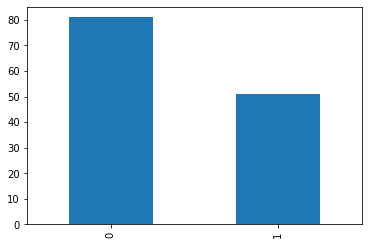

In [14]:
counts = snp_occurence_df['occurence'].value_counts()
counts.plot(kind = 'bar')
print(counts)

In [15]:
snp_occurence_df.to_csv("imp_snp_occurance.csv", index = False)

In [6]:
snp_occurence_df = pd.read_csv("imp_snp_occurance.csv")

In [7]:
snp_imp = list(snp_occurence_df[snp_occurence_df['occurence'] == 1]['common_id'])
print("Important SNPs associated with PD in MasterDB =", len(snp_imp))

Important SNPs associated with PD in MasterDB = 51


In [8]:
snp_imp

['chr1_20977000_A_C',
 'chr1_20977748_T_G',
 'chr1_20977856_T_C',
 'chr17_44039691_A_G',
 'chr17_44061278_C_T',
 'chr17_44068924_G_A',
 'chr17_44073889_A_G',
 'chr17_44073973_T_C',
 'chr17_44102604_T_C',
 'chr17_44104509_T_C',
 'chr4_90637010_A_G',
 'chr4_90637601_G_A',
 'chr4_90639515_G_T',
 'chr4_90641340_T_C',
 'chr4_90642464_A_T',
 'chr4_90643757_C_G',
 'chr4_90646886_G_A',
 'chr4_90655003_T_C',
 'chr4_90657491_C_T',
 'chr4_90663542_T_C',
 'chr4_90664794_C_T',
 'chr4_90666041_C_T',
 'chr4_90668019_A_G',
 'chr4_90674431_G_A',
 'chr4_90675238_A_G',
 'chr4_90678541_G_A',
 'chr4_90678798_G_A',
 'chr4_90693476_C_G',
 'chr4_90703753_T_C',
 'chr4_90705364_A_G',
 'chr4_90707947_T_C',
 'chr4_90711770_T_C',
 'chr4_90721637_C_G',
 'chr4_90722871_C_T',
 'chr4_90729602_A_G',
 'chr4_90734728_A_G',
 'chr4_90740878_G_A',
 'chr4_90745707_G_A',
 'chr4_90757309_A_G',
 'chr4_90757394_G_C',
 'chr4_90757505_T_C',
 'chr4_90757735_C_A',
 'chr4_90757845_C_T',
 'chr4_90758389_G_C',
 'chr4_90758945_A_G',
 'c

### Finding correlated SNPs with the selected 51 SNPs 

In [24]:
snp_corr = dict()

In [25]:
critical_c = 3.84
for snp in snp_imp: 
    print(snp_imp.index(snp)+1,"SNP -> ",snp)
    snp_corr[snp] = {}
    k = 0
    for x in snp_list:
        if(k%3000==0):
            print(k)
        if(x != snp):
            contigency = pd.crosstab(master_df[snp], master_df[x])
            c, p, dof, expected = chi2_contingency(contigency)
            if(c > critical_c):
                snp_corr[snp][x] = c
        k+=1

1 SNP ->  chr1_20977000_A_C
0
3000
6000
2 SNP ->  chr1_20977748_T_G
0
3000
6000
3 SNP ->  chr1_20977856_T_C
0
3000
6000
4 SNP ->  chr17_44039691_A_G
0
3000
6000
5 SNP ->  chr17_44061278_C_T
0
3000
6000
6 SNP ->  chr17_44068924_G_A
0
3000
6000
7 SNP ->  chr17_44073889_A_G
0
3000
6000
8 SNP ->  chr17_44073973_T_C
0
3000
6000
9 SNP ->  chr17_44102604_T_C
0
3000
6000
10 SNP ->  chr17_44104509_T_C
0
3000
6000
11 SNP ->  chr4_90637010_A_G
0
3000
6000
12 SNP ->  chr4_90637601_G_A
0
3000
6000
13 SNP ->  chr4_90639515_G_T
0
3000
6000


KeyboardInterrupt: 

In [3]:
# # Saving snp_corr
# f = open("snp_corr.pkl","wb")
# pickle.dump(snp_corr,f)
# f.close()

# Loading snp_corr
filename = "snp_corr.pkl"
f = open(filename,'rb')
snp_corr = pickle.load(f)
f.close()

In [4]:
snp_corr

{'chr1_20977000_A_C': {'chr1_20977221_A_T': 9.923284571814728,
  'chr1_20977365_C_G': 7.570600281419192,
  'chr1_20977449_G_T': 88.87547795556316,
  'chr1_20978058_G_A': 15.5564616100401,
  'chr1_151668982_G_T': 4.345343733449357,
  'chr1_205738166_T_C': 4.521582193149927,
  'chr4_90713064_G_A': 3.9110880835802724,
  'chr4_90713330_C_G': 4.19313400364932,
  'chr4_90722871_C_T': 5.255144973340779,
  'chr4_90730687_C_A': 5.973689136600648,
  'chr4_90734728_A_G': 5.580623026439316,
  'chr4_90736517_T_C': 4.887310390082943,
  'chr4_90737327_G_A': 5.880671635705719,
  'chr4_90738158_G_C': 5.580623026439316,
  'chr4_90739539_C_A': 5.535670387296268,
  'chr4_90743855_C_G': 4.335621785657496,
  'chr4_90746329_T_C': 5.525128318963642,
  'chr4_90746709_C_T': 5.63690242522593,
  'chr4_90748710_G_A': 5.201483844412065,
  'chr4_90757394_G_C': 4.49675255043714,
  'chr4_90761412_T_C': 6.976853708560348,
  'chr4_90762622_A_T': 6.6136848216911,
  'chr4_90765213_C_T': 6.084878387280509,
  'chr4_90767433

In [9]:
# Number of SNPs related to the each Imp SNP
for snp in snp_imp: 
    print(snp_imp.index(snp)+1,"SNP:",snp,"->",len(snp_corr[snp]))

1 SNP: chr1_20977000_A_C -> 80
2 SNP: chr1_20977748_T_G -> 80
3 SNP: chr1_20977856_T_C -> 83
4 SNP: chr17_44039691_A_G -> 4475
5 SNP: chr17_44061278_C_T -> 88
6 SNP: chr17_44068924_G_A -> 86
7 SNP: chr17_44073889_A_G -> 96
8 SNP: chr17_44073973_T_C -> 88
9 SNP: chr17_44102604_T_C -> 95
10 SNP: chr17_44104509_T_C -> 84
11 SNP: chr4_90637010_A_G -> 457
12 SNP: chr4_90637601_G_A -> 503
13 SNP: chr4_90639515_G_T -> 804
14 SNP: chr4_90641340_T_C -> 519
15 SNP: chr4_90642464_A_T -> 546
16 SNP: chr4_90643757_C_G -> 547
17 SNP: chr4_90646886_G_A -> 563
18 SNP: chr4_90655003_T_C -> 700
19 SNP: chr4_90657491_C_T -> 808
20 SNP: chr4_90663542_T_C -> 561
21 SNP: chr4_90664794_C_T -> 807
22 SNP: chr4_90666041_C_T -> 525
23 SNP: chr4_90668019_A_G -> 700
24 SNP: chr4_90674431_G_A -> 555
25 SNP: chr4_90675238_A_G -> 808
26 SNP: chr4_90678541_G_A -> 578
27 SNP: chr4_90678798_G_A -> 427
28 SNP: chr4_90693476_C_G -> 400
29 SNP: chr4_90703753_T_C -> 556
30 SNP: chr4_90705364_A_G -> 4125
31 SNP: chr4_907079

### Selecting Top 20 of the SNPs correlated with selected 51 SNPs

In [12]:
# taking top 20 followed by union
snp_corr_filt = {}
for snp in snp_imp: 
    snp_corr_filt[snp] = list(dict(sorted(snp_corr[snp].items(), key=lambda item: item[1], reverse=True)).keys())[:20]

In [30]:
snp_corr_filt['chr1_20977000_A_C']

['chr1_20977748_T_G',
 'chr1_20977380_T_C',
 'chr1_20977856_T_C',
 'chr1_20978024_C_A',
 'chr1_20972111_G_A',
 'chr1_20977449_G_T',
 'chr1_20977599_C_G',
 'chr1_20978058_G_A',
 'chr16_31000809_G_A',
 'chr1_20977221_A_T',
 'chr12_40762502_T_C',
 'chr16_30995528_A_G',
 'chr16_30995669_T_C',
 'chr5_122111005_G_T',
 'chr6_109002518_A_G',
 'chr12_105504953_T_C',
 'chr1_20977365_C_G',
 'chr5_122165828_T_C',
 'chr4_90761412_T_C',
 'chr4_90767433_C_T']

In [11]:
# Number of SNPs related to the each Imp SNP
for snp in snp_imp: 
    print(snp_imp.index(snp)+1,"SNP:",snp,"->",len(snp_corr_filt[snp]))

1 SNP: chr1_20977000_A_C -> 20
2 SNP: chr1_20977748_T_G -> 20
3 SNP: chr1_20977856_T_C -> 20
4 SNP: chr17_44039691_A_G -> 20
5 SNP: chr17_44061278_C_T -> 20
6 SNP: chr17_44068924_G_A -> 20
7 SNP: chr17_44073889_A_G -> 20
8 SNP: chr17_44073973_T_C -> 20
9 SNP: chr17_44102604_T_C -> 20
10 SNP: chr17_44104509_T_C -> 20
11 SNP: chr4_90637010_A_G -> 20
12 SNP: chr4_90637601_G_A -> 20
13 SNP: chr4_90639515_G_T -> 20
14 SNP: chr4_90641340_T_C -> 20
15 SNP: chr4_90642464_A_T -> 20
16 SNP: chr4_90643757_C_G -> 20
17 SNP: chr4_90646886_G_A -> 20
18 SNP: chr4_90655003_T_C -> 20
19 SNP: chr4_90657491_C_T -> 20
20 SNP: chr4_90663542_T_C -> 20
21 SNP: chr4_90664794_C_T -> 20
22 SNP: chr4_90666041_C_T -> 20
23 SNP: chr4_90668019_A_G -> 20
24 SNP: chr4_90674431_G_A -> 20
25 SNP: chr4_90675238_A_G -> 20
26 SNP: chr4_90678541_G_A -> 20
27 SNP: chr4_90678798_G_A -> 20
28 SNP: chr4_90693476_C_G -> 20
29 SNP: chr4_90703753_T_C -> 20
30 SNP: chr4_90705364_A_G -> 20
31 SNP: chr4_90707947_T_C -> 20
32 SNP: ch

### Adding the 51 SNP to final union list  

In [16]:
snp_final_filt = []
for snp in snp_imp: 
    snp_final_filt.append(snp)
    snp_final_filt = snp_final_filt + snp_corr_filt[snp]

In [17]:
len(snp_final_filt)

1071

In [18]:
len(set(snp_final_filt))

335

In [34]:
with open("fea_selected.txt", 'w') as output:
    for row in set(snp_final_filt):
        output.write(str(row) + '\n')

#### Top SNPs by occurance in final 335

In [19]:
snp_final_filt = []
for snp in snp_imp: 
#     snp_final_filt.append(snp)
    snp_final_filt = snp_final_filt + snp_corr_filt[snp]

In [20]:
len(snp_final_filt)

1020

In [27]:
# Finding occurances 
dict_occur = dict(Counter(snp_final_filt))
dict_occur = dict(sorted(dict_occur.items(), key=lambda item: item[1], reverse=True))
dict_occur

{'chr4_90666041_C_T': 9,
 'chr4_90668614_T_C': 9,
 'chr4_90637010_A_G': 9,
 'chr4_90745503_C_T': 9,
 'chr4_90747183_G_A': 9,
 'chr17_44091724_G_A': 8,
 'chr17_44102638_A_G': 8,
 'chr17_44102865_A_C': 8,
 'chr17_44103616_C_T': 8,
 'chr17_44102933_T_C': 8,
 'chr17_44103296_T_C': 8,
 'chr17_44061036_T_C': 8,
 'chr17_44104343_A_C': 8,
 'chr17_44061023_G_A': 8,
 'chr17_44067400_T_C': 8,
 'chr4_90641340_T_C': 8,
 'chr4_90646886_G_A': 8,
 'chr4_90643757_C_G': 8,
 'chr4_90642464_A_T': 8,
 'chr4_90678541_G_A': 8,
 'chr4_90663542_T_C': 8,
 'chr4_90674431_G_A': 8,
 'chr4_90637601_G_A': 8,
 'chr4_90747207_C_T': 8,
 'chr17_44102604_T_C': 7,
 'chr17_44101563_T_C': 7,
 'chr17_44104509_T_C': 7,
 'chr17_44061278_C_T': 7,
 'chr17_44073973_T_C': 7,
 'chr17_44068924_G_A': 7,
 'chr17_44073889_A_G': 7,
 'chr17_44101871_A_G': 7,
 'chr17_44060775_C_T': 7,
 'chr17_44102689_G_C': 7,
 'chr17_44105395_A_G': 7,
 'chr4_90643857_G_A': 7,
 'chr4_90643921_G_C': 7,
 'chr4_90644281_A_G': 7,
 'chr4_90713064_G_A': 7,
 'ch

In [36]:
# Top 24 by occurance (Min occurances = 8)
snps_24_occur = list(dict(sorted(dict_occur.items(), key=lambda item: item[1], reverse=True)).keys())[:24]
snps_24_occur

with open("snps_24_occur.txt", 'w') as output:
    for row in set(snps_24_occur):
        output.write(str(row) + '\n')

In [31]:
# Top 46 by occurance (Min occurances = 7)
snps_46_occur = list(dict(sorted(dict_occur.items(), key=lambda item: item[1], reverse=True)).keys())[:46]
snps_46_occur

['chr4_90666041_C_T',
 'chr4_90668614_T_C',
 'chr4_90637010_A_G',
 'chr4_90745503_C_T',
 'chr4_90747183_G_A',
 'chr17_44091724_G_A',
 'chr17_44102638_A_G',
 'chr17_44102865_A_C',
 'chr17_44103616_C_T',
 'chr17_44102933_T_C',
 'chr17_44103296_T_C',
 'chr17_44061036_T_C',
 'chr17_44104343_A_C',
 'chr17_44061023_G_A',
 'chr17_44067400_T_C',
 'chr4_90641340_T_C',
 'chr4_90646886_G_A',
 'chr4_90643757_C_G',
 'chr4_90642464_A_T',
 'chr4_90678541_G_A',
 'chr4_90663542_T_C',
 'chr4_90674431_G_A',
 'chr4_90637601_G_A',
 'chr4_90747207_C_T',
 'chr17_44102604_T_C',
 'chr17_44101563_T_C',
 'chr17_44104509_T_C',
 'chr17_44061278_C_T',
 'chr17_44073973_T_C',
 'chr17_44068924_G_A',
 'chr17_44073889_A_G',
 'chr17_44101871_A_G',
 'chr17_44060775_C_T',
 'chr17_44102689_G_C',
 'chr17_44105395_A_G',
 'chr4_90643857_G_A',
 'chr4_90643921_G_C',
 'chr4_90644281_A_G',
 'chr4_90713064_G_A',
 'chr4_90713330_C_G',
 'chr4_90738158_G_C',
 'chr4_90748710_G_A',
 'chr4_90730687_C_A',
 'chr4_90749686_A_G',
 'chr4_9075

***Check how many of the 51 occur in the finalised lists***

In [33]:
# Intersection with top 24 (Min occurance = 8)
set1 = set(snp_imp)
set2 = set(snps_24_occur)

print(len(list(set1 & set2)))
list(set1 & set2)

10


['chr4_90643757_C_G',
 'chr4_90663542_T_C',
 'chr4_90642464_A_T',
 'chr4_90674431_G_A',
 'chr4_90666041_C_T',
 'chr4_90637601_G_A',
 'chr4_90646886_G_A',
 'chr4_90637010_A_G',
 'chr4_90678541_G_A',
 'chr4_90641340_T_C']

In [34]:
# Intersection with top 46 (Min occurance = 7)
set1 = set(snp_imp)
set2 = set(snps_46_occur)

print(len(list(set1 & set2)))
list(set1 & set2)

17


['chr4_90643757_C_G',
 'chr4_90663542_T_C',
 'chr17_44104509_T_C',
 'chr4_90642464_A_T',
 'chr4_90674431_G_A',
 'chr4_90666041_C_T',
 'chr17_44101563_T_C',
 'chr4_90637601_G_A',
 'chr17_44102604_T_C',
 'chr4_90646886_G_A',
 'chr4_90637010_A_G',
 'chr17_44073889_A_G',
 'chr4_90678541_G_A',
 'chr17_44073973_T_C',
 'chr17_44061278_C_T',
 'chr17_44068924_G_A',
 'chr4_90641340_T_C']